# Visualize Bx, By, Bz from Surya and Real HMI Data

This notebook visualizes the magnetic field components (Bx, By, Bz) from:
1. **Surya-generated data** (with inverse_transform applied)
2. **Real HMI B data** (from FITS files in `datasets/hmi.B`)

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import yaml
import pandas as pd
import sunpy.visualization.colormaps as cm

# Import utility functions
from magnetogram_utils import (
    load_magnetogram_sample,
    load_hmi_observed_magnetogram,
    plot_magnetogram_comparison
)

## Load Surya Magnetogram

Load one sample from Surya dataset. The `load_magnetogram_sample` function automatically applies inverse_transform to convert normalized values to physical units (Gauss).

In [2]:
# Load Surya magnetogram (inverse_transform is applied automatically)
config_path = "./configs/config_magnetogram_test.yaml"
print("Loading Surya magnetogram...")
magnetogram_surya, velocity_np, timestamp, dataset = load_magnetogram_sample(config_path, sample_idx=0)

print(f"\nSurya magnetogram shape: {magnetogram_surya.shape}")
print(f"  Bx range: [{magnetogram_surya[0].min():.1f}, {magnetogram_surya[0].max():.1f}] G")
print(f"  By range: [{magnetogram_surya[1].min():.1f}, {magnetogram_surya[1].max():.1f}] G")
print(f"  Bz range: [{magnetogram_surya[2].min():.1f}, {magnetogram_surya[2].max():.1f}] G")

# Print timestamp
if timestamp is not None:
    if isinstance(timestamp, pd.Timestamp):
        timestamp_str = timestamp.strftime('%Y%m%d_%H%M%S')
    else:
        timestamp_str = pd.Timestamp(timestamp).strftime('%Y%m%d_%H%M%S')
    print(f"\nTimestamp: {timestamp_str}")
else:
    print("\nTimestamp: Not available")

Loading Surya magnetogram...

Surya magnetogram shape: (3, 4096, 4096)
  Bx range: [-1404.5, 1751.1] G
  By range: [-1687.0, 1060.4] G
  Bz range: [-1128.6, 1019.6] G

Timestamp: 20110116_000000


## Load Real HMI B Magnetogram

Load the corresponding real HMI B data from FITS files. The data is converted from spherical coordinates (field, inclination, azimuth) to Cartesian (Bx, By, Bz).

In [3]:
# Load real HMI B magnetogram
hmi_b_dir = "./datasets/hmi.B"

# Use the timestamp from Surya data, or use a default timestamp
if timestamp is not None:
    if isinstance(timestamp, pd.Timestamp):
        timestamp_for_hmi = timestamp
    else:
        timestamp_for_hmi = pd.Timestamp(timestamp)
else:
    # Default to first available timestamp: 20110116_000000
    timestamp_for_hmi = pd.Timestamp('2011-01-16 00:00:00')
    print(f"Warning: No timestamp from Surya data, using default: {timestamp_for_hmi}")

print(f"\nLoading real HMI B magnetogram for timestamp: {timestamp_for_hmi}")
try:
    magnetogram_hmi, H_hmi, W_hmi = load_hmi_observed_magnetogram(hmi_b_dir, timestamp_for_hmi)
    # Rotate observed HMI Bx, By, Bz by 2 (180 degrees)
    magnetogram_hmi = np.rot90(magnetogram_hmi, k=2, axes=(1, 2))
    print(f"\nHMI magnetogram shape: {magnetogram_hmi.shape}")
    print(f"  Bx range: [{magnetogram_hmi[0].min():.1f}, {magnetogram_hmi[0].max():.1f}] G")
    print(f"  By range: [{magnetogram_hmi[1].min():.1f}, {magnetogram_hmi[1].max():.1f}] G")
    print(f"  Bz range: [{magnetogram_hmi[2].min():.1f}, {magnetogram_hmi[2].max():.1f}] G")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Trying to find available timestamps...")
    # List available timestamps
    field_files = list(Path(hmi_b_dir).glob("hmi.b_720s.*.field.fits"))
    if field_files:
        # Extract timestamp from first file
        first_file = field_files[0].name
        # Format: hmi.b_720s.20110116_000000_TAI.field.fits
        timestamp_str = first_file.split('_TAI')[0].replace('hmi.b_720s.', '')
        print(f"Using first available timestamp: {timestamp_str}")
        timestamp_for_hmi = pd.Timestamp(timestamp_str.replace('_', ' '))
        magnetogram_hmi, H_hmi, W_hmi = load_hmi_observed_magnetogram(hmi_b_dir, timestamp_for_hmi)
        # Rotate observed HMI Bx, By, Bz by 2 (180 degrees) and make a contiguous copy
        magnetogram_hmi = np.rot90(magnetogram_hmi, k=2, axes=(1, 2)).copy()
        print(f"\nHMI magnetogram shape: {magnetogram_hmi.shape}")
        print(f"  Bx range: [{magnetogram_hmi[0].min():.1f}, {magnetogram_hmi[0].max():.1f}] G")
        print(f"  By range: [{magnetogram_hmi[1].min():.1f}, {magnetogram_hmi[1].max():.1f}] G")
        print(f"  Bz range: [{magnetogram_hmi[2].min():.1f}, {magnetogram_hmi[2].max():.1f}] G")
    else:
        raise FileNotFoundError(f"No HMI B files found in {hmi_b_dir}")


Loading real HMI B magnetogram for timestamp: 2011-01-16 00:00:00
Loaded disambiguation file for timestamp 20110116_000000
Applied disambiguation: 5838337 pixels flipped (out of 16777216 total)

HMI magnetogram shape: (3, 4096, 4096)
  Bx range: [nan, nan] G
  By range: [nan, nan] G
  Bz range: [nan, nan] G


## Individual Component Visualizations

Create separate visualizations for each component (Bx, By, Bz) with better control over colormaps and scaling.

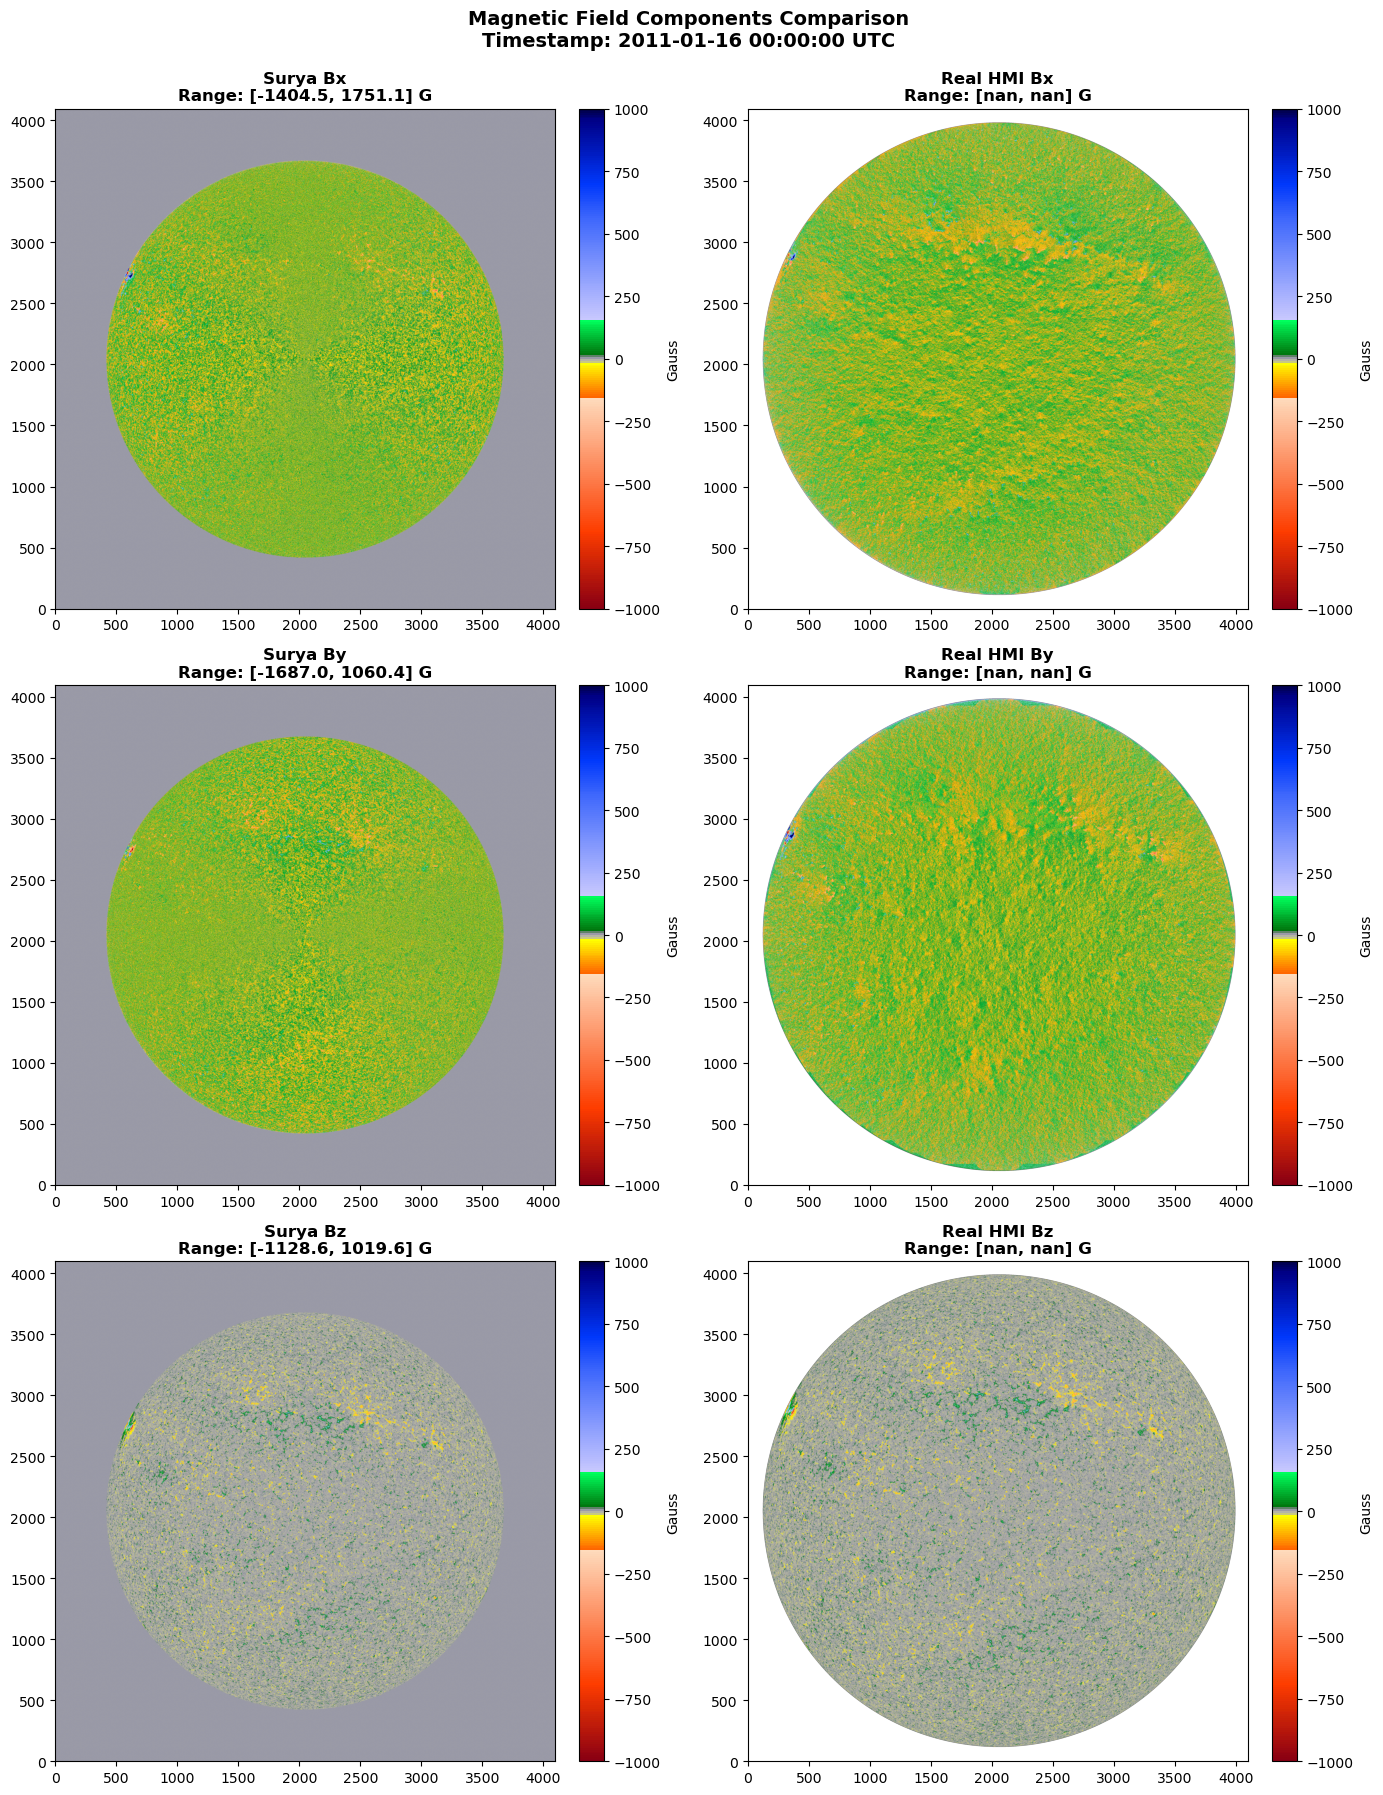

In [13]:
# Create individual visualizations for each component
component_names = ['Bx', 'By', 'Bz']
fig, axes = plt.subplots(3, 2, figsize=(14, 18))

lim = 1000  # Fixed limit for all magnetogram components

for i, comp_name in enumerate(component_names):
    # Surya data
    surya_data = magnetogram_surya[i]
    vmin_surya = surya_data.min()
    vmax_surya = surya_data.max()
    
    im1 = axes[i, 0].imshow(surya_data, cmap='hmimag', origin='lower',
                           vmin=-lim, vmax=lim)
    axes[i, 0].set_title(f'Surya {comp_name}\nRange: [{vmin_surya:.1f}, {vmax_surya:.1f}] G', 
                        fontsize=12, fontweight='bold')
    plt.colorbar(im1, ax=axes[i, 0], fraction=0.046, pad=0.04, label='Gauss')
    
    # HMI data
    hmi_data = magnetogram_hmi[i]
    vmin_hmi = hmi_data.min()
    vmax_hmi = hmi_data.max()
    
    im2 = axes[i, 1].imshow(hmi_data, cmap='hmimag', origin='lower',
                          vmin=-lim, vmax=lim)
    axes[i, 1].set_title(f'Real HMI {comp_name}\nRange: [{vmin_hmi:.1f}, {vmax_hmi:.1f}] G', 
                        fontsize=12, fontweight='bold')
    plt.colorbar(im2, ax=axes[i, 1], fraction=0.046, pad=0.04, label='Gauss')

plt.suptitle(f'Magnetic Field Components Comparison\nTimestamp: {timestamp_str_for_plot}', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()